### OC spatial structure

- 2D, 3D structure
- Model fitting
- tidal, core radii


In [20]:
using PyCall
using Distributions, Statistics, Distances
using DataFrames
using LightGraphs, SimpleWeightedGraphs
using Random , Printf, Glob

import PyPlot , CSV
import Distances, StatsBase

rootdir = ENV["GAIA_ROOT"]

push!(LOAD_PATH,"$rootdir/master/src")
using GaiaClustering

## directory
wdir    = "$rootdir/products"
plotdir = "$rootdir/products/test"
ocdir= "$wdir/oc2"

cd(wdir)

In [21]:
## radial functions
##

function volumeSphere(r)
    return(4 / 3 * π * r^3)
end

function areaDisk(r)
    return(π * r^2)
end

function _density2D(x , y , nbin=10 )
    center= [mean(x) ; mean(y)]
    
    nxy= length(x)
    A= Array{Float64}(undef,2,nxy)
    for i in 1:nxy
        A[1,i]= x[i]
        A[2,i]= y[i]
    end
    
    d= Distances.Euclidean()
    r= Distances.colwise(d, A, center)
    
    ρ= [] ; radius= [] ; err= []
    rmax= maximum(r)
    dr= rmax/nbin
    r0=0
    for i in 1:nbin
        r1= i*dr
        indr= (r .> r0) .& (r .<= r1)
        nstar= count(indr)
        dens= nstar/(areaDisk(r1)-areaDisk(r0))
        if nstar > 0 
            errDensity= dens / sqrt(nstar)
        else
            errDensity= 1e9
        end
        
        push!(ρ, dens)
        push!(radius, (r1+r0)/2)
        push!(err, errDensity)
        r0= r1
    end
    
    return(radius, ρ , err)
end

function _density3D(x , y , z, nbin=10)
    center= [mean(x) ; mean(y) ; mean(z)]
    println(center)
    
    nxy= length(x)
    A= Array{Float64}(undef,3,nxy)
    for i in 1:nxy
        A[1,i]= x[i]
        A[2,i]= y[i]
        A[3,i]= z[i]
    end
    
    d= Distances.Euclidean()
    r= Distances.colwise(d, A, center)
    
    ρ= [] ; radius= [] ; err=[]
    rmax= maximum(r)
    dr= rmax/nbin
    r0=0
    for i in 1:nbin
        r1= i*dr
        indr= (r .> r0) .& (r .<= r1)
        nstar= count(indr)
        dens= nstar/(volumeSphere(r1)-volumeSphere(r0))
        errDensity= dens / sqrt(nstar)
        push!(ρ, dens)
        push!(radius, (r1+r0)/2)
        push!(err, errDensity)
        r0= r1
    end
    
    return(radius, ρ , err)
end

_density3D (generic function with 2 methods)

In [22]:
## Estimation of the local density around each point
## nei: number of neighbor to estimate the density
##

function _locdens2d(x , y , nei=10)
    nxy= length(x)
    A= Array{Float64}(undef,2,nxy)
    center= [mean(x) ; mean(y)]
    
    for i in 1:nxy
        A[:,i]= [x[i] y[i]]
    end
    
    d= Euclidean()
    p= pairwise(d, A, A, dims=2)
    r= Distances.colwise(d, A, center)
    locdensrad= []
    
    for i in 1:nxy
        rsort= sort(p[i,:])
        rmax= rsort[nei+1]
        locdens= (nei+1)/areaDisk(rmax)
        push!(locdensrad, locdens)
    end
    
    return(r,locdensrad)
end

function _locdens3d(x , y , z, nei=10)
    nxyz= length(x)
    A= Array{Float64}(undef,3,nxyz)
    center= [mean(x) ; mean(y) ; mean(z)]
    
    for i in 1:nxyz
        A[:,i]= [x[i] y[i] z[i]]
    end
    
    d= Euclidean()
    p= pairwise(d, A, A, dims=2)
    r= Distances.colwise(d, A, center)
    locdensrad= []
    
    for i in 1:nxyz
        rsort= sort(p[i,:])
        rmax= rsort[nei+1]
        locdens= (nei+1)/volumeSphere(rmax)
        push!(locdensrad, locdens)
    end
    
    return(r,locdensrad)
end

_locdens3d (generic function with 2 methods)

In [23]:
#oc= CSV.read("$ocdir/NGC 6124-2.3deg-oc.csv" , delim= ";")
# oc= CSV.read("$ocdir/NGC 7086-1.0deg-oc.csv", delim= ";")
# oc= CSV.read("$ocdir/NGC 2516-3.5deg-oc.csv", delim= ";")
oc= CSV.read("test.csv", delim= ";")

r2d,ρ2d,err2d= _density2D(oc.Y, oc.Z,20)
r3d,ρ3d,err3d= _density3D(oc.Y, oc.Y, oc.Z,20)

println("## !! X changed for Y to check computation!!")
rad2d, locdens2d= _locdens2d(oc.Y, oc.Z, 100)
rad3d, locdens3d= _locdens3d(oc.Y,oc.Y, oc.Z, 10)

println("##")

[0.5860203142692046, 0.5860203142692046, 0.41948622857646956]
## !! X changed for Y to check computation!!
##


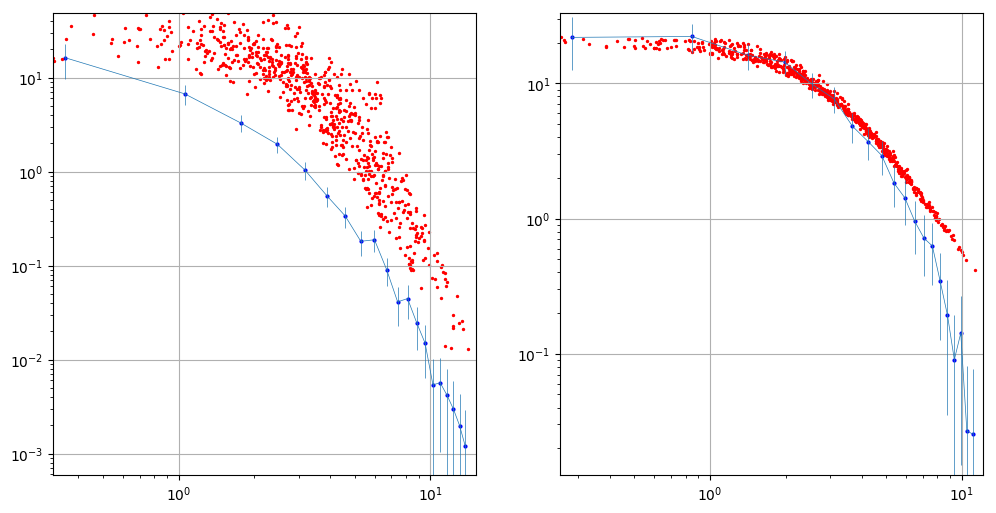

In [24]:
fig= PyPlot.figure(figsize=(12,6))
ax= PyPlot.subplot(121)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(minimum(r3d)*0.9, maximum(r3d)*1.1)
ax.set_ylim(minimum(ρ3d[ρ3d .> 0])*0.5,maximum(ρ3d)*3)
PyPlot.grid("on")
PyPlot.scatter(r3d, ρ3d , s=4, facecolor="blue" )
PyPlot.errorbar(r3d, ρ3d, yerr=2 .* err3d, linewidth=0.5)
PyPlot.scatter(rad3d, locdens3d , s=2, facecolor="red" )

ax= PyPlot.subplot(122)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(r2d[1]*0.9, r2d[end]*1.1)
ax.set_ylim(minimum(ρ2d[ρ2d .> 0])*0.5,maximum(ρ2d)*1.5)
PyPlot.grid("on")
PyPlot.scatter(r2d, ρ2d , s=4, facecolor="blue" )
PyPlot.errorbar(r2d, ρ2d, yerr=2 .* err2d, linewidth=0.5)
PyPlot.scatter(rad2d, locdens2d , s=2, facecolor="red" )

PyPlot.show()

We try to fit the radial density (using MCMC?). It will be used later for the fractal dimension (including the radial density inside).

## Fitting the radial profile


In [25]:
## position from the gravity centered
struct _sc2dcentered
    nxy::Int
    xx::Array{Float64}
    yy::Array{Float64}
    radius::Array{Float64}
    dens::Array{Float64}
    nbin::Int
    radbin::Array{Float64}
    densbin::Array{Float64}
    densbinerr::Array{Float64}
end

## prior model / mcmc
mutable struct _mcmcCauchy
    Cmean::Float64
    Cdisp::Float64
    smean::Float64
    sdisp::Float64
    mmean::Float64
    mdisp::Float64
    nburnin::Int
    niter::Int
end

mutable struct _modelCauchy
    C::Float64
    s::Float64
    m::Float64 
end

mutable struct _mcCauchy
    C::Array{Float64}
    s::Array{Float64}
    m::Array{Float64}
end

In [26]:
## density and likelihood functions
function _fdens1(r, θ::_modelCauchy)
    r2= r*r
    s2= θ.s*θ.s
    val = θ.C / (1+r2/s2)^θ.m
    return(val)
end

function _fdens1log(r, θ::_modelCauchy)
    r2= r*r
    s2= exp(θ.s)*exp(θ.s)
    val = θ.C - θ.m * log(1+r2/s2)
    return(val)
end

## using local density for all points
function _likelihood2d(θ::_modelCauchy, oc::_sc2dcentered)
    χ2= 0
    for i in 1:oc.nxy
        desti= _fdens1(oc.radius[i], θ)
        χ2+= ((desti-oc.dens[i])^2)/oc.nxy     ## σ=1
    end
    p = min(1, exp(-χ2))
    return(p)
end

### binnned 2D density
function _likelihood2dbin(θ::_modelCauchy, oc::_sc2dcentered)
    χ2= 0
    for i in 1:oc.nbin
        desti= _fdens1(oc.radbin[i], θ)
        χ2+= ((desti-oc.densbin[i]) / oc.densbinerr[i])^2
    end
    # p = min(1, exp(-χ2))
    p= min(1, 1/χ2)
    return(p)
end

### binnned 2D/3D density log
### LOG
function _likelihood2dbinlog(θ::_modelCauchy, oc::_sc2dcentered)
    χ2= 0
    for i in 1:oc.nbin
        desti= _fdens1log(oc.radbin[i], θ)
        χ2+= ((desti-oc.densbin[i]) / 1)^2
        #println(i)
        #println(θ)
        #println(oc.densbin[i])
        #println(desti)
    end
    p = min(1, exp(-χ2))

    return(p)
end

_likelihood2dbinlog (generic function with 1 method)

# Metropolis-Hasting

https://twiecki.io/blog/2015/11/10/mcmc-sampling/

proposal = norm(mu_current, proposal_width).rvs()

Next, you evaluate whether that's a good place to jump to or not. If the resulting normal distribution with that proposed mu explaines the data better than your old mu, you'll definitely want to go there. What does "explains the data better" mean? We quantify fit by computing the probability of the data, given the likelihood (normal) with the proposed parameter values (proposed mu and a fixed sigma = 1). This can easily be computed by calculating the probability for each data point using scipy.stats.normal(mu, sigma).pdf(data) and then multiplying the individual probabilities, i.e. compute the likelihood (usually you would use log probabilities but we omit this here):

likelihood_current = norm(mu_current, 1).pdf(data).prod() <br>
likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod() <br>

# Compute prior probability of current and proposed mu        
prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current) <br>
prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal) <br>

# Nominator of Bayes formula
p_current = likelihood_current * prior_current <br>
p_proposal = likelihood_proposal * prior_proposal <br>

Up until now, we essentially have a hill-climbing algorithm that would just propose movements into random directions and only accept a jump if the mu_proposal has higher likelihood than mu_current. Eventually we'll get to mu = 0 (or close to it) from where no more moves will be possible. However, we want to get a posterior so we'll also have to sometimes accept moves into the other direction. The key trick is by dividing the two probabilities,

p_accept = p_proposal / p_current <br> 

we get an acceptance probability. You can already see that if p_proposal is larger, that probability will be > 1 and we'll definitely accept. However, if p_current is larger, say twice as large, there'll be a 50% chance of moving there:

accept = np.random.rand() < p_accept

if accept:
    # Update position
    cur_pos = proposal

In [27]:
function _theta(mcmc::_mcmcCauchy, oc::_sc2dcentered, likelihood::Function, firstvalue::Bool)
    pC  = Normal(mcmc.Cmean, mcmc.Cdisp)
    pm  = Normal(mcmc.mmean, mcmc.mdisp)
    ps  = Normal(mcmc.smean, mcmc.sdisp)
    
    if firstvalue
        C= mcmc.Cmean 
        s= mcmc.smean
        m= mcmc.mmean
    else
        C = rand(pC)
        s = rand(ps)
        m = rand(pm) 
    end
       
    pdfC = pdf(pC,C)   
    pdfm = pdf(pm, m)  
    pdfs = pdf(ps, s)
        
    θ= _modelCauchy(C, s, m)
    
    pdfC = pdf(pC , C)
    pdfm = pdf(pm, m)
    pdfs = pdf(ps, s)
    ptotal = pdfC*pdfm*pdfs*likelihood(θ, oc)
    
    return(θ, ptotal) 
end


## next iteration
function _thetaiter(θi::_modelCauchy, mcmc::_mcmcCauchy, oc::_sc2dcentered, likelihood::Function)
    pC  = Normal(mcmc.Cmean, mcmc.Cdisp)
    pm  = Normal(mcmc.mmean, mcmc.mdisp)
    ps  = Normal(mcmc.smean, mcmc.sdisp)
    
    C_rw= Normal(θi.C, 0.5)
    s_rw= Normal(θi.s  , 0.5)
    m_rw= Normal(θi.m , 0.5)

    new_C = 0.
    new_m = 0
    new_s = 0
        
    new_C  = rand(C_rw)
    new_m =  rand(m_rw)     
    new_s =  rand(s_rw)
    
    θ= _modelCauchy(new_C, new_s, new_m)
   
    pdfC = pdf(pC , new_C)
    pdfm = pdf(pm, new_m)
    pdfs = pdf(ps, new_s)
    ptotal = pdfC*pdfm*pdfs*likelihood(θ, oc)
    
    return(θ, ptotal)
end

_thetaiter (generic function with 1 method)

In [28]:
## Main MCMC to estimate parameters
## firstvalue: true(set to mean), false(random from prior)
function main_mcmc(oc::_sc2dcentered, mcmc::_mcmcCauchy, likelihood::Function, firstvalue=false , verbose=true)
    let
        mci = _mcCauchy(zeros(Float64,0),zeros(Float64,0),zeros(Float64,0))
        mi, probi = _theta(mcmc, oc, likelihood, firstvalue)
        if verbose println("## Init done...") end
    
        niter = mcmc.niter
        nburn = mcmc.nburnin
        nchain = 1
        loopAgain = true
        burndone = false
        ηbest= 0 ; θbest= 0
        
        while loopAgain
            micurrent, probcurrent = _thetaiter(mi , mcmc, oc, likelihood)
   
        ### Metropolis-Hasting
            α = probcurrent / probi
            if α > rand() 
                mi = micurrent
                probi = probcurrent
                nchain += 1
                if (nchain%50000 == 0 && verbose ) println("### chain:",nchain) end
                if nchain > nburn && !burndone  nchain = 0 ; burndone = true end    ## burnin done
                if nchain > niter loopAgain = false end
                if burndone    
                    push!(mci.C, mi.C)
                    push!(mci.s, mi.s)
                    push!(mci.m, mi.m)
                end
            else
                nchain += 1
                if (nchain%50000 == 0 && verbose) println("### chain:",nchain) end
                if nchain > nburn && !burndone   nchain = 0 ; burndone = true end    ## burnin done
                if nchain > niter loopAgain = false end
                if burndone    
                    push!(mci.C, mi.C)
                    push!(mci.s, mi.s)
                    push!(mci.m, mi.m)
                end                    
            end
            
            η= likelihood(mi, oc)
            if η > ηbest
                ηbest= η
                θbest= mi
            end
        end
        
        if verbose println("## MCMC 2D fitting done.") end
        
        return(mci, θbest, ηbest)
    end
end

main_mcmc (generic function with 3 methods)

In [29]:
function _model_rad(radius, θ, densModel::Function)
    ρfit= [] 
    for i in 1:length(radius)
        ρ= densModel(radius[i], θ)
        push!(ρfit, ρ)
    end
    
    return(ρfit)
end

_model_rad (generic function with 1 method)

### Updated below with the src/ stable version... (main_mcmc renamed)

In [30]:
## main for 2D fitting
ocfile= "$ocdir/NGC 6025-1.7deg-oc-mass.csv"
oc= CSV.read(ocfile, delim= ";")

## binned density
nbin= 20
r2d,ρ2d,err2d= _density2D(oc.Y, oc.Z, nbin)    ## binned radius
r3d,ρ3d,err3d= _density3D(oc.X, oc.Y, oc.Z, nbin)

## local density
nloc= 3
rad_2d, loc_2d= _locdens2d(oc.Y, oc.Z, nloc)    ## density estimated for each point
rad_3d, loc_3d= _locdens3d(oc.X,oc.Y, oc.Z, nloc)    

oc2d= _sc2dcentered(length(oc.Y), oc.Y, oc.Z, rad_2d, loc_2d , nbin , r2d, ρ2d, err2d )
##only 3D binned density
oc3d= _sc2dcentered(length(oc.Y), oc.Y, oc.Z, rad_3d, loc_3d , nbin , r3d, ρ3d, err3d )
oc3dlog= _sc2dcentered(length(oc.Y), oc.Y, oc.Z, rad_3d, loc_3d , nbin , r3d, log.(ρ3d), err3d ./ ρ3d )

## prior
C_mean= 15
C_disp= 10
s_mean= 10
s_disp= 5
m_mean= 3
m_disp= 2
#
nburnin= 50000
niter= 1000000

pinit= _mcmcCauchy(C_mean, C_disp, s_mean, s_disp, m_mean, m_disp, nburnin, niter)

##
## if true it takes the mean as first step, otherwise random
println("## Running mcmc (2/3)D fitting")
println("## stars: $(length(oc.X))")

mci ,  θbest  = main_mcmc(oc2d, pinit, _likelihood2dbin, false) 


#println("## Running mcmc 3D fitting")
#mci ,  θbest  = main_mcmc(oc3d, pinit, _likelihood2dbin , false) 

@printf("## C: %3.3f (%3.3f) \n", median(mci.C), std(mci.C))
@printf("## s: %3.3f (%3.3f) \n", median(mci.s), std(mci.s))
@printf("## m: %3.3f (%3.3f) \n", median(mci.m), std(mci.m))
Cmed= median(mci.C)
smed= median(mci.s)
mmed= median(mci.m)
θmed= _modelCauchy(Cmed, smed, mmed)

println("##")
println("## Best solution")
@printf("## C: %3.3f \n", θbest.C)
@printf("## s: %3.3f \n", θbest.s)
@printf("## m: %3.3f \n", θbest.m)

## compute the radial distribution for the fitted law
## LOG solution
# θbest= _modelCauchy(exp(θbest.C), exp(θbest.s), exp(θbest.m))
# println(θbest)

ρ2dfit= _model_rad(r2d, θbest, _fdens1)
ρ2dmed= _model_rad(r2d, θmed, _fdens1)
#ρ3dfit= _model_rad(r3d, θbest, _fdens1)
#ρ3dmed= _model_rad(r3d, θmed, _fdens1)

println("## Done")

[783.7583196685587, -1.5040292383793454, -1.1314810938240039]
## Running mcmc (2/3)D fitting
## stars: 332
## Init done...
### chain:50000
### chain:50000
### chain:100000
### chain:150000
### chain:200000
### chain:250000
### chain:300000
### chain:350000
### chain:400000
### chain:450000
### chain:500000
### chain:550000
### chain:600000
### chain:650000
### chain:700000
### chain:750000
### chain:800000
### chain:850000
### chain:900000
### chain:950000
### chain:1000000
## MCMC 2D fitting done.
## C: 8.028 (6.775) 
## s: 5.952 (3.503) 
## m: 4.063 (1.570) 
##
## Best solution
## C: 7.143 
## s: 5.151 
## m: 2.838 
## Done


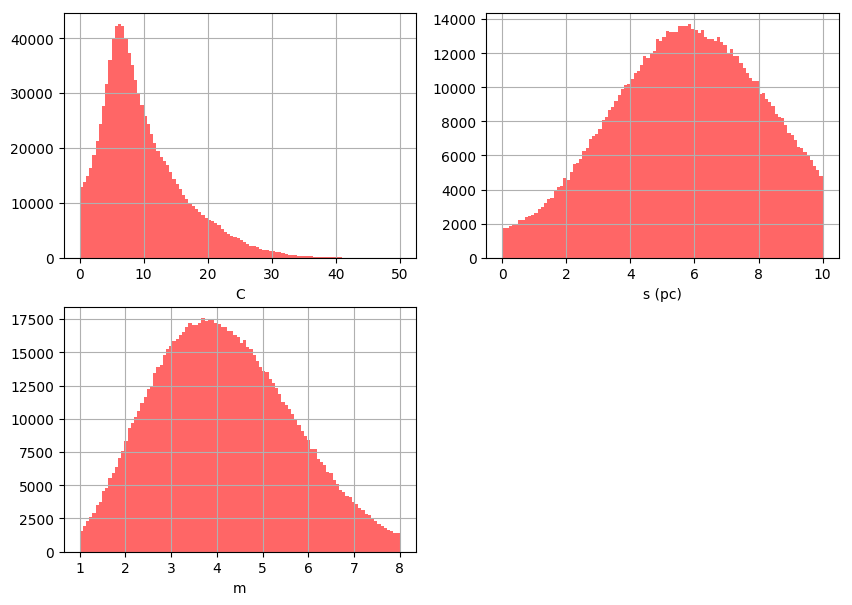

In [31]:
### Plot the results
###
fig = PyPlot.figure(figsize=(10,7))

ax = PyPlot.subplot(221)
PyPlot.grid("on")
nbins = 100
h = PyPlot.hist(mci.C,nbins,range = [0,50], color = "r", alpha=0.6 , label = "C")
PyPlot.xlabel("C")


ax = PyPlot.subplot(222)
PyPlot.grid("on")
nbins = 100
h = PyPlot.hist(mci.s,nbins,range = [0.,10], color = "r", alpha=0.6 , label = "C")
PyPlot.xlabel("s (pc)")

ax = PyPlot.subplot(223)
PyPlot.grid("on")
nbins = 100
h = PyPlot.hist(mci.m,nbins,range = [1,8], color = "r", alpha=0.6 , label = "C")
PyPlot.xlabel("m")

PyPlot.show()

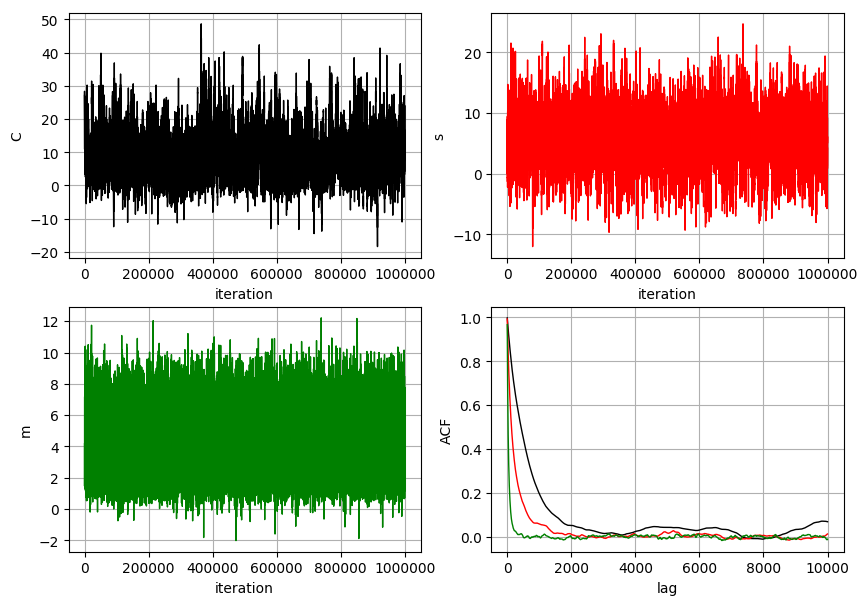

In [32]:
## Iterationss

fig = PyPlot.figure(figsize=(10,7))

ax = PyPlot.subplot(221)
PyPlot.grid("on")
PyPlot.xlabel("iteration")
PyPlot.ylabel("C")
PyPlot.plot(mci.C, "k-", linewidth= 1)
    
ax = PyPlot.subplot(222)
PyPlot.grid("on")
PyPlot.xlabel("iteration")
PyPlot.ylabel("s")
PyPlot.plot(mci.s, "r-", linewidth= 1)

ax = PyPlot.subplot(223)
PyPlot.grid("on")
PyPlot.xlabel("iteration")
PyPlot.ylabel("m")
PyPlot.plot(mci.m, "g-", linewidth= 1)

lags= collect(1:10000)
ax = PyPlot.subplot(224)
PyPlot.grid("on")
PyPlot.xlabel("lag")
PyPlot.ylabel("ACF")
PyPlot.plot(StatsBase.autocor(mci.C, lags), "k-", linewidth= 1)
PyPlot.plot(StatsBase.autocor(mci.s, lags), "r-", linewidth= 1)
PyPlot.plot(StatsBase.autocor(mci.m, lags), "g-", linewidth= 1)

PyPlot.show()

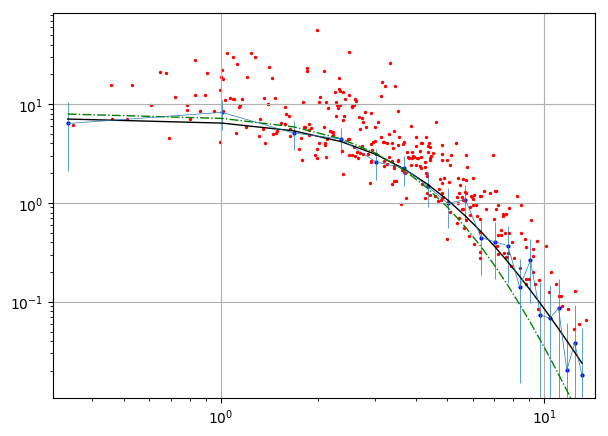

_modelCauchy(7.142735039447861, 5.150992854000701, 2.837886671946872)


In [33]:
fig= PyPlot.figure(figsize=(7,5))

ax= PyPlot.subplot(111)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(r2d[1]*0.9, r2d[end]*1.1)
ax.set_ylim(minimum(loc_2d[loc_2d .> 0])*0.2,maximum(loc_2d)*1.5)
PyPlot.grid("on")
PyPlot.scatter(r2d, ρ2d , s=4, facecolor="blue" )
PyPlot.errorbar(r2d, ρ2d, yerr=2 .* err2d, linewidth=0.5)
PyPlot.scatter(rad_2d, loc_2d , s=2, facecolor="red" )
PyPlot.plot(r2d, ρ2dfit, "k-", linewidth=1)
PyPlot.plot(r2d, ρ2dmed, "g-.", linewidth=1)

#ax.set_xlim(r3d[1]*0.9, r3d[end]*1.1)
#ax.set_ylim(minimum(ρ3d[ρ3d .> 0])*0.5,maximum(loc_3d)*1.5)
#PyPlot.scatter(r3d, ρ3d , s=4, facecolor="blue" )
#PyPlot.errorbar(r3d, ρ3d, yerr=2 .* err3d, linewidth=0.5)
#PyPlot.scatter(rad_3d, loc_3d , s=2, facecolor="red" )
#PyPlot.plot(r3d, ρ3dfit, "k-", linewidth=1)
#PyPlot.plot(r3d, ρ3dmed, "g-.", linewidth=1)

PyPlot.show()

println(θbest)

For the spatial parameters using mcmc the following items are important:
* _thetaiter : the dispersion of the random walk step to allow jump from local minima
* the prior should be well chosen to speed up the convergence
* eventually the initial value should be set (not random from prior)
* 3D local and binned density are not consistent yet
* Check ACF for the parameters
* The 3D local estimation for each stars does not look correct yet (or the binned estimation..)

--------
### Full automatization and check ...

In [34]:
## Estimate  prior parameters

function _priorGuess(rad, dens)
    
    m= 3
    mdisp= 2
    
    C= maximum(dens)
    Cdisp= C/2
    
    s= StatsBase.mean(rad, StatsBase.weights(convert(Array{Float64,1}, dens)))
    sdisp= s/2
    
    priorMean= _modelCauchy(C, s, m)
    priorDisp= _modelCauchy(Cdisp, sdisp, mdisp)
    
    return(priorMean, priorDisp)
end

## extract parameters
## 

function _extract_parameter(ocfile, ntest=10 , nbin=20, niter=10000 ,verbose=true)
    let 
        solC= []; sols= []; solm= []
        ηBest= 1e9 ; θBest= 0 
    
        oc= CSV.read(ocfile, delim= ";")
        if verbose println("## file $ocfile read...") end

        ## binned density
        r2d,ρ2d,err2d= _density2D(oc.Y, oc.Z, nbin)    ## binned radius
        r3d,ρ3d,err3d= _density3D(oc.X, oc.Y, oc.Z, nbin)
    
        ## local density
        ## not used yet...
        nloc= 3
        rad_2d, loc_2d= _locdens2d(oc.Y, oc.Z, nloc)    ## density estimated for each point
        rad_3d, loc_3d= _locdens3d(oc.X,oc.Y, oc.Z, nloc)    

        oc2d= _sc2dcentered(length(oc.Y), oc.Y, oc.Z, rad_2d, loc_2d , nbin , r2d, ρ2d, err2d )
        ##only 3D binned density
        oc3d= _sc2dcentered(length(oc.Y), oc.Y, oc.Z, rad_3d, loc_3d , nbin , r3d, ρ3d, err3d )
        oc3dlog= _sc2dcentered(length(oc.Y), oc.Y, oc.Z, rad_3d, loc_3d , nbin , r3d, log.(ρ3d), err3d ./ ρ3d )

        if verbose println("## Density profiles computed...") end
    
        ## prior
        ##
         prior, priorDisp= _priorGuess(r2d, ρ2d)
        if verbose
            println("## Prior Guess:")
            println(prior)
            println("## prior estimated...")
        end
        C_mean= prior.C ; C_disp= priorDisp.C
        s_mean= prior.s ; s_disp= priorDisp.s
        m_mean= prior.m ; m_disp= priorDisp.m

        nburnin= 10000

        pinit= _mcmcCauchy(C_mean, C_disp, s_mean, s_disp, m_mean, m_disp, nburnin, niter)


        ## AFC < 0.1
        ## if true it takes the mean as first step, otherwise random
        if verbose println("## Running mcmc (2/3)D fitting") end

        for i in 1:ntest        
            mci ,  θbest , ηbest = main_mcmc(oc2d, pinit, _likelihood2dbin, false, verbose)

            lags= collect(1:1000)
            acfC= StatsBase.autocor(mci.C, lags)[end]
            acfs= StatsBase.autocor(mci.s, lags)[end]
            acfm= StatsBase.autocor(mci.m, lags)[end]
            
            if verbose
                println("## test: $i")
                println(θbest)
                println("## Likelihood: $ηbest")
                println("## ACF(C,s,m): $acfC , $acfs , $acfm")
            end
            
            if abs(acfC) < 0.1 && abs(acfs) < 0.1 && abs(acfm) < 0.1
                push!(solC,abs(θbest.C))
                push!(sols,abs(θbest.s))
                push!(solm,abs(θbest.m))
                if ηbest < ηBest
                    ηBest= ηbest
                    θBest= θbest
                end
            end
        end
        
        println(solC)
        println(sols)
        println(solm)
        
        θerr= _modelCauchy(std(solC),std(sols),std(solm))

        if θBest.C<0 || θBest.s<0 || θBest.m<0
            θBest.C= abs(θBest.C) 
            θBest.s= abs(θBest.s)
            θBest.m= abs(θBest.m)
        end
        return(θBest, θerr)
    end
end


_extract_parameter (generic function with 5 methods)

In [35]:
ocfile= "test.csv"
ntest= 1000 ; nbin=20 ; niter=50000
θfit, θfiterr= _extract_parameter(ocfile, ntest, nbin, niter, true)


## file test.csv read...
[1470.032772875999, 0.5860203142692046, 0.41948622857646956]
## Density profiles computed...
## Prior Guess:
_modelCauchy(22.20574694993412, 1.9508792719595207, 3.0)
## prior estimated...
## Running mcmc (2/3)D fitting
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 1
_modelCauchy(21.412068165712476, 5.426316938964616, 3.725735632853274)
## Likelihood: 0.06871978846595084
## ACF(C,s,m): 0.4951053389499364 , 0.01697895747039396 , 0.007893573330597257
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 2
_modelCauchy(21.195938054140058, 5.5655526958687505, 3.7182872244510468)
## Likelihood: 0.07503106036777404
## ACF(C,s,m): 0.039094906378017165 , 0.02293082194389646 , 0.03814837308002177
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 3
_modelCauchy(24.80570420447328, 4.527847767144053, 3.0777212783245456)
## Likelihood: 0.052509721482793495
## ACF(C,s,m): 0.3515258506050864 , 0.008276813998107639 , 0.04202429456

### chain:50000
## MCMC 2D fitting done.
## test: 33
_modelCauchy(22.99960187904377, 4.87479853094312, 3.2692709092876897)
## Likelihood: 0.06343693593204433
## ACF(C,s,m): 0.6163375610674647 , 0.023043260045322856 , -0.010771262850897224
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 34
_modelCauchy(22.272367554507547, 4.933098214545245, 3.3136628807653143)
## Likelihood: 0.06291857203965887
## ACF(C,s,m): 0.5390835907352607 , -0.010755764031250423 , -0.004559458343432709
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 35
_modelCauchy(21.177798601065582, 5.553073822833506, 3.754099771761739)
## Likelihood: 0.07589230936425984
## ACF(C,s,m): 0.27694051582112894 , -0.0023315800225297586 , -0.021132468519352066
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 36
_modelCauchy(23.895710095037973, 5.184293610992809, 3.6066117981756367)
## Likelihood: 0.062654973476959
## ACF(C,s,m): 0.5483809974523183 , 0.016730080217095007 , 0.023853188

### chain:50000
## MCMC 2D fitting done.
## test: 65
_modelCauchy(21.70683928246983, 5.506134116172889, 3.737675806735269)
## Likelihood: 0.07626484671385608
## ACF(C,s,m): 0.5350289588522348 , 0.012456521030764936 , 0.04761707827906533
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 66
_modelCauchy(22.334356639021212, 5.15860809117038, 3.472976310789894)
## Likelihood: 0.07020786792694231
## ACF(C,s,m): 0.4062506465156078 , 0.001247796812729553 , 0.026712533483661576
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 67
_modelCauchy(21.57567592701177, 5.672981322059749, 4.02695956750439)
## Likelihood: 0.06268125580943469
## ACF(C,s,m): 0.531625726190815 , -0.017050800935830397 , 0.009730966835642101
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 68
_modelCauchy(22.340258139586933, 5.616439829093551, 3.8183288414527716)
## Likelihood: 0.07089450951417701
## ACF(C,s,m): 0.2873081527615556 , -0.0031661422153571347 , -0.0416841806851372

### chain:50000
## MCMC 2D fitting done.
## test: 98
_modelCauchy(19.29018705593125, 6.0083747917394446, 4.052254415447314)
## Likelihood: 0.06746296264798318
## ACF(C,s,m): 0.30043586479655165 , -0.003030645232461412 , -0.0005736490778809354
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 99
_modelCauchy(24.02387458648977, 4.872249761506098, 3.3338271738250227)
## Likelihood: 0.06076890686184443
## ACF(C,s,m): 0.5096830837326843 , 0.0040653076134861705 , -0.013031534334157427
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 100
_modelCauchy(23.002793362861492, 5.32608389332227, 3.6089812217934236)
## Likelihood: 0.06741281536544089
## ACF(C,s,m): 0.3730621095430141 , -0.02313810359102535 , 0.00871272996086519
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 101
_modelCauchy(23.30052430741054, 5.216411373573102, 3.532992268566975)
## Likelihood: 0.0653897395918827
## ACF(C,s,m): 0.22745270428693037 , 0.02133924052052529 , -0.013628588

### chain:50000
## MCMC 2D fitting done.
## test: 130
_modelCauchy(21.649692195769465, 5.5308009979686865, 3.7118875793019708)
## Likelihood: 0.07472279865074298
## ACF(C,s,m): 0.48587945563065077 , -0.004661941725824158 , -0.06217477175753216
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 131
_modelCauchy(21.12081908664519, 5.753222428378177, 3.866257013711728)
## Likelihood: 0.07621772913151263
## ACF(C,s,m): 0.3400562774028176 , 0.030861588993928844 , 0.0013198402548225728
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 132
_modelCauchy(23.988424402191132, 5.034939035846945, 3.443640241217425)
## Likelihood: 0.06184612741416457
## ACF(C,s,m): 0.3532179965412271 , -0.019075450115461592 , 0.010264949410764624
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 133
_modelCauchy(22.99073988582788, 5.6607854196503435, 3.943783065463563)
## Likelihood: 0.06732455125832151
## ACF(C,s,m): 0.4787657081805611 , -0.0016212428931070984 , 0.0056

### chain:50000
## MCMC 2D fitting done.
## test: 162
_modelCauchy(20.735081570200784, 5.501263367111336, 3.757971615958825)
## Likelihood: 0.0654106672102578
## ACF(C,s,m): 0.25349594970366696 , 0.0034990390650696474 , -0.03894625836261198
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 163
_modelCauchy(19.699541507811766, 6.229226451189598, 4.3218959238032255)
## Likelihood: 0.07256233099487726
## ACF(C,s,m): 0.5573058493790143 , 0.004969439184504915 , 0.024017882817871886
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 164
_modelCauchy(22.99220830509664, 5.4314799271386685, 3.8004694185634125)
## Likelihood: 0.06823421201766877
## ACF(C,s,m): 0.30130738734608736 , 0.00678820640795239 , -0.010683434276773663
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 165
_modelCauchy(23.014613889677314, 5.449741223497762, 3.7311590948535414)
## Likelihood: 0.06804239067118939
## ACF(C,s,m): 0.3955036125621965 , 0.0020305114320102228 , -0.0057

### chain:50000
## MCMC 2D fitting done.
## test: 194
_modelCauchy(23.314159774220276, 4.808725110766421, 3.2394665475264075)
## Likelihood: 0.061694704063798414
## ACF(C,s,m): 0.21186186323349337 , 0.01607340775557001 , -0.031043390334389718
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 195
_modelCauchy(23.21445565681537, 4.935383872712769, 3.3342081781286437)
## Likelihood: 0.06470680116105754
## ACF(C,s,m): 0.41426601867951063 , 0.0029829795357061055 , 0.03752153877055469
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 196
_modelCauchy(22.92300139392754, 5.334075044190454, 3.615409380582968)
## Likelihood: 0.06833913635514996
## ACF(C,s,m): 0.22065815941699818 , 0.009282296227972907 , 0.0043715979589024605
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 197
_modelCauchy(22.441168807095206, 5.294642938828893, 3.528672594962089)
## Likelihood: 0.0675586717213596
## ACF(C,s,m): 0.4270059493226976 , -0.04075605904498476 , -0.012644

### chain:50000
## MCMC 2D fitting done.
## test: 226
_modelCauchy(22.149329291765753, 5.361870599599466, 3.66589151188066)
## Likelihood: 0.07318257360911991
## ACF(C,s,m): 0.36653467905314746 , -0.023660673403473782 , 0.020124492893459467
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 227
_modelCauchy(22.678342716951065, 5.553016067918061, 3.876444668796419)
## Likelihood: 0.07114921217340231
## ACF(C,s,m): 0.44849217374860983 , 0.01774243824326512 , -0.0138983760677976
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 228
_modelCauchy(19.980144761444443, 6.434963413881485, 4.461636763332691)
## Likelihood: 0.07861589631968247
## ACF(C,s,m): 0.29620018691511013 , -0.004309649052740565 , -0.014742149609586898
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 229
_modelCauchy(21.26146777201384, 5.277969215877708, 3.5228049287813055)
## Likelihood: 0.06947053689711218
## ACF(C,s,m): 0.535401919554526 , -0.015149822015268074 , -0.0432619

### chain:50000
## MCMC 2D fitting done.
## test: 258
_modelCauchy(22.223251213154022, 5.258814302507651, 3.573287150192528)
## Likelihood: 0.07181856281820807
## ACF(C,s,m): 0.47955117810788556 , -0.004544156475896015 , 0.014371264382699235
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 259
_modelCauchy(22.108677144418536, 5.197986518851183, 3.444564642305744)
## Likelihood: 0.06822225660217744
## ACF(C,s,m): 0.4191948920441605 , -0.010844067307154513 , -0.005949411282542031
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 260
_modelCauchy(22.985064427478306, 4.958814860556505, 3.3600823691160966)
## Likelihood: 0.06525756371231001
## ACF(C,s,m): 0.2731573824649718 , 0.017380779731279838 , 0.004390918947242186
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 261
_modelCauchy(21.405319052681527, 5.281189280414342, 3.530516121040832)
## Likelihood: 0.07052212351136279
## ACF(C,s,m): 0.48281676592080774 , 0.017509016035536777 , 0.00432

### chain:50000
## MCMC 2D fitting done.
## test: 290
_modelCauchy(20.69805465938338, 5.769665061344954, 3.956572769923575)
## Likelihood: 0.07487570168698114
## ACF(C,s,m): 0.508543245629554 , 0.029868400671856175 , -0.004881433792507152
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 291
_modelCauchy(21.436415332099923, 5.66348987587947, 3.89115749864753)
## Likelihood: 0.07705543612348688
## ACF(C,s,m): 0.4456498678149475 , -0.014075562726371765 , -0.013633781594648392
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 292
_modelCauchy(22.977395269844955, 5.274909960671539, 3.625936844066516)
## Likelihood: 0.06977877493115596
## ACF(C,s,m): 0.1996513382982702 , 0.001963100375483726 , 0.009639624275711979
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 293
_modelCauchy(22.375435702394167, 5.537891761160585, 3.779870297615604)
## Likelihood: 0.07333196236629105
## ACF(C,s,m): 0.3337208430979719 , 0.028585248226878617 , 0.010933238541

### chain:50000
## MCMC 2D fitting done.
## test: 322
_modelCauchy(21.89996323506578, 5.337821259797874, 3.6864294206337487)
## Likelihood: 0.06716852643657428
## ACF(C,s,m): 0.30707011492193886 , 0.011521612845494397 , -0.05054327658827702
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 323
_modelCauchy(22.49186081646202, 5.344390302249596, 3.679296114303483)
## Likelihood: 0.07167379827031096
## ACF(C,s,m): 0.35317265448182306 , 0.0330560848759585 , -0.009945112957313562
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 324
_modelCauchy(20.905127664049697, 5.68488899125861, 3.8271300789325777)
## Likelihood: 0.07709486325597237
## ACF(C,s,m): 0.3770933511973687 , -0.0035037777222378204 , 0.017628998852783732
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 325
_modelCauchy(22.849315178853356, 5.348780806904033, 3.6321531123515753)
## Likelihood: 0.0695184012159411
## ACF(C,s,m): 0.5459739377789522 , -0.00920150267177476 , 0.019377040

### chain:50000
## MCMC 2D fitting done.
## test: 354
_modelCauchy(22.66338657452645, 4.775517358579665, 3.176314788611629)
## Likelihood: 0.059848665127891394
## ACF(C,s,m): 0.5371503713070286 , -0.01226417053983237 , 0.025896685870197594
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 355
_modelCauchy(20.24112555742175, 5.86936793569176, 3.993331745265817)
## Likelihood: 0.07507025385485362
## ACF(C,s,m): 0.283350217276095 , 0.010609452564002584 , 0.029083574994112935
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 356
_modelCauchy(23.134447641081614, 5.193946697145455, 3.573142843085743)
## Likelihood: 0.06813254446469814
## ACF(C,s,m): 0.296282381557905 , -0.03170898227996037 , -0.0038404251204733762
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 357
_modelCauchy(22.017753071341314, 5.499654191311691, 3.7687308398871484)
## Likelihood: 0.07543709002314672
## ACF(C,s,m): 0.45096906973689693 , -0.001308327853483716 , -0.038607378

### chain:50000
## MCMC 2D fitting done.
## test: 386
_modelCauchy(23.01315973617611, 5.26466978918675, 3.651988634731158)
## Likelihood: 0.06787587334160085
## ACF(C,s,m): 0.052315285306449445 , 0.004808860922336214 , -0.01550842625098131
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 387
_modelCauchy(21.48920926059225, 5.708375291184924, 3.894097866388033)
## Likelihood: 0.07823477157575424
## ACF(C,s,m): 0.3069042004646158 , 0.00371464261079775 , -0.026679193589865736
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 388
_modelCauchy(21.82449458667588, 5.102439207050557, 3.3433099786548777)
## Likelihood: 0.06423719870011861
## ACF(C,s,m): 0.3583305543984496 , -0.028192442179334948 , 0.00289204123938246
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 389
_modelCauchy(22.301198352428678, 5.591415810423446, 3.9499426743915995)
## Likelihood: 0.06781120498453087
## ACF(C,s,m): 0.29746436125257764 , -0.003751301247220676 , -0.00950167

### chain:50000
## MCMC 2D fitting done.
## test: 418
_modelCauchy(22.79480828181887, 5.043526875097765, 3.3428558034699694)
## Likelihood: 0.06369037842042452
## ACF(C,s,m): 0.18898953435624316 , -0.016657860078195925 , -0.003900085628426364
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 419
_modelCauchy(21.637573502083352, 5.231188680123231, 3.552257876575915)
## Likelihood: 0.06712610719668721
## ACF(C,s,m): 0.3716712111067816 , -0.017740091758561876 , 0.003385035904643628
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 420
_modelCauchy(22.413425873863677, 4.94538035729718, 3.255549247956023)
## Likelihood: 0.062397829245861264
## ACF(C,s,m): 0.4385219706865777 , -0.015591962410266596 , 0.007346306439666722
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 421
_modelCauchy(22.452828666378082, 4.884335882765172, 3.2832807500284105)
## Likelihood: 0.06198006741631647
## ACF(C,s,m): 0.3308799033152609 , 0.003352026658789509 , 0.01733

### chain:50000
## MCMC 2D fitting done.
## test: 450
_modelCauchy(21.243382870253402, 5.208486441801416, 3.439865082050828)
## Likelihood: 0.06716353538908196
## ACF(C,s,m): 0.22535815996573658 , 0.012008690798208937 , 0.01354673053145655
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 451
_modelCauchy(21.597532910451125, 5.521037156235259, 3.7247494053201926)
## Likelihood: 0.07613578921978274
## ACF(C,s,m): 0.333971440713534 , 0.00607095344481676 , 0.05750717421437735
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 452
_modelCauchy(21.385982355177433, 5.149243972806664, 3.3571527861267265)
## Likelihood: 0.06340562762685173
## ACF(C,s,m): 0.3463874814912079 , -0.026779597939927458 , -0.06405907030151443
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 453
_modelCauchy(22.29268731019389, 5.324905804230142, 3.625333766424598)
## Likelihood: 0.07308768942925717
## ACF(C,s,m): 0.25702961584013767 , 0.011977058026631463 , -0.0083812909

### chain:50000
## MCMC 2D fitting done.
## test: 482
_modelCauchy(21.926243236124435, 5.421093846318243, 3.741781328275457)
## Likelihood: 0.07098494885390796
## ACF(C,s,m): 0.22932048345023343 , -0.027358531878018358 , 0.01654497441565673
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 483
_modelCauchy(21.38753934309232, 5.213702111667005, 3.503422293695351)
## Likelihood: 0.06698424849401034
## ACF(C,s,m): 0.2092299866824364 , 0.014997579940788965 , -0.0035223873072856723
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 484
_modelCauchy(22.56299686251398, 5.262351015562606, 3.5738812004920995)
## Likelihood: 0.07169564417611683
## ACF(C,s,m): 0.4989102654697592 , -0.017971864322081206 , -0.014041023913104845
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 485
_modelCauchy(21.820665661976644, 5.902151163329424, 4.022159461983468)
## Likelihood: 0.07021651315249713
## ACF(C,s,m): 0.3440582240652133 , 0.01598142098730789 , -0.0197825

### chain:50000
## MCMC 2D fitting done.
## test: 514
_modelCauchy(21.264209141547575, 5.526703208285051, 3.7228764244017443)
## Likelihood: 0.07586154332664909
## ACF(C,s,m): 0.4948585482124971 , -0.023336792834477448 , 0.04266384844663018
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 515
_modelCauchy(20.71821541244925, 5.980647839064954, 4.0859203956616845)
## Likelihood: 0.07965854036510418
## ACF(C,s,m): 0.3470987281160436 , -0.008710821441508757 , -0.018743843692774632
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 516
_modelCauchy(23.332005761586338, 5.140211712536272, 3.47766369249187)
## Likelihood: 0.06554687250293291
## ACF(C,s,m): 0.31445341271769967 , -0.007501389056021262 , -0.008879893546580558
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 517
_modelCauchy(22.326267692097016, 5.533263774963271, 3.8525705831451793)
## Likelihood: 0.07239646232931096
## ACF(C,s,m): 0.5284632967432601 , 0.007761912136016368 , 0.02821

### chain:50000
## MCMC 2D fitting done.
## test: 546
_modelCauchy(22.329622291924153, 5.500869183238331, 3.8246917804772744)
## Likelihood: 0.072176129349679
## ACF(C,s,m): 0.27207381858871355 , 0.013970187206062218 , 0.023874912699003114
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 547
_modelCauchy(21.57564996751516, 5.234982746257504, 3.4901070591375514)
## Likelihood: 0.0701469943775702
## ACF(C,s,m): 0.249026735504905 , -0.019534118785980673 , 0.007412451413831228
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 548
_modelCauchy(22.28886163249175, 5.536673387961533, 3.7733291373360274)
## Likelihood: 0.07386550884705903
## ACF(C,s,m): 0.4501370437599484 , 0.0243818772248601 , -0.014176334743619196
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 549
_modelCauchy(22.27121862839753, 5.316951316046681, 3.5974051272787753)
## Likelihood: 0.07304320888703127
## ACF(C,s,m): 0.627027734138896 , -0.023204394125185664 , 0.0102975653093

### chain:50000
## MCMC 2D fitting done.
## test: 578
_modelCauchy(21.894110854723024, 5.686794884683369, 3.9242121491066033)
## Likelihood: 0.07679355570003274
## ACF(C,s,m): 0.39653372899949235 , 0.009386852131029362 , -0.006353643788958615
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 579
_modelCauchy(22.525560123699975, 5.822223286549862, 4.115044347065975)
## Likelihood: 0.07017849949312993
## ACF(C,s,m): 0.08386536144369619 , 0.0018413574237687404 , -0.029154184724983868
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 580
_modelCauchy(22.45633735883422, 5.3716586481848205, 3.6933960817630567)
## Likelihood: 0.072490828347874
## ACF(C,s,m): 0.36813274207212565 , 0.011815401209051413 , -0.01221550309882691
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 581
_modelCauchy(22.53285815875606, 5.009827615321121, 3.4251372112843748)
## Likelihood: 0.06289906730070279
## ACF(C,s,m): 0.455156745960141 , -0.01734149675102014 , 0.032913

### chain:50000
## MCMC 2D fitting done.
## test: 610
_modelCauchy(22.982043408766497, 5.155499383378995, 3.4622081882537463)
## Likelihood: 0.0666390125523811
## ACF(C,s,m): 0.5345663016033525 , 0.0035760189172494247 , 0.031130214116965833
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 611
_modelCauchy(22.0655790237245, 5.121987813829134, 3.3972455643164663)
## Likelihood: 0.06784144141677277
## ACF(C,s,m): 0.43973637822923556 , -0.026194322762342327 , 0.023659407003551465
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 612
_modelCauchy(23.27585546955287, 5.015518593073971, 3.3530411156050812)
## Likelihood: 0.06304113106317157
## ACF(C,s,m): 0.5189008741315921 , 0.026297582287825215 , -0.004735293119928215
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 613
_modelCauchy(23.811719149472456, 5.176875675629952, 3.6112076518044747)
## Likelihood: 0.06277853842048225
## ACF(C,s,m): 0.33742395817753557 , -0.005456081383440951 , 0.00917

### chain:50000
## MCMC 2D fitting done.
## test: 642
_modelCauchy(22.780747243332947, 5.199177711307307, 3.6050799955436337)
## Likelihood: 0.0659207046212537
## ACF(C,s,m): 0.3502442235427759 , 0.010490750083859482 , -0.03589526282405256
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 643
_modelCauchy(22.250053890321407, 5.555379713609597, 3.8369342912710125)
## Likelihood: 0.07464254006847104
## ACF(C,s,m): 0.4071381485169412 , 0.004234762852972626 , 0.03655111334673127
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 644
_modelCauchy(22.51401898987625, 5.268072371436488, 3.627620143198535)
## Likelihood: 0.06968628604186776
## ACF(C,s,m): 0.5348245564226822 , 0.014971839223108999 , -0.015769557275226814
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 645
_modelCauchy(20.717866346484946, 5.837031733667378, 3.9422533453153066)
## Likelihood: 0.07817829906315327
## ACF(C,s,m): 0.3324111228603315 , 0.01777499342898896 , 0.00520699349

### chain:50000
## MCMC 2D fitting done.
## test: 674
_modelCauchy(21.325678534983005, 5.544214700313813, 3.769168464650854)
## Likelihood: 0.07574337651795914
## ACF(C,s,m): 0.3885185070765449 , -0.03269070032685147 , 0.001248275474068899
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 675
_modelCauchy(21.143727078378742, 5.8369495619439125, 3.9685369533824324)
## Likelihood: 0.07862656525732167
## ACF(C,s,m): 0.3644472134126665 , 0.007593850595092451 , 0.04146734113121065
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 676
_modelCauchy(23.879665602957893, 4.9379693578513315, 3.3659228714027742)
## Likelihood: 0.06219844734944119
## ACF(C,s,m): 0.3900685666454934 , 0.005148045468366587 , -0.0013284351722713961
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 677
_modelCauchy(21.753925476175795, 5.21628827003998, 3.5179341976625)
## Likelihood: 0.0695330520021546
## ACF(C,s,m): 0.35653031861412304 , -0.0014405614388676518 , 0.0203255

### chain:50000
## MCMC 2D fitting done.
## test: 706
_modelCauchy(22.068433085346264, 5.407764869415441, 3.6361792351270554)
## Likelihood: 0.07324313449264779
## ACF(C,s,m): 0.31354139382791196 , -0.023086747982016036 , 0.02781989453092148
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 707
_modelCauchy(22.640826972062186, 5.15851175161815, 3.4319005592804532)
## Likelihood: 0.06616890195921007
## ACF(C,s,m): 0.2613380137660044 , -0.02430869575366223 , 0.05058902499258726
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 708
_modelCauchy(20.281672838804116, 5.733057101592832, 3.8031697558391873)
## Likelihood: 0.07289276002062277
## ACF(C,s,m): 0.1264122407910156 , 0.03701891549459031 , 0.010132796862147159
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 709
_modelCauchy(23.600241986478412, 5.4168113519157846, 3.735298618544088)
## Likelihood: 0.06252006544157598
## ACF(C,s,m): 0.3942554162789786 , 0.02803568452977356 , 0.0174011813

### chain:50000
## MCMC 2D fitting done.
## test: 738
_modelCauchy(21.960483312636654, 5.623899337119648, 3.9609954285654267)
## Likelihood: 0.06867482141117918
## ACF(C,s,m): 0.3737910564617115 , 0.02163104117291278 , -0.03277472947385433
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 739
_modelCauchy(22.39575302197333, 5.477360717354858, 3.7971678753808376)
## Likelihood: 0.0725834867246907
## ACF(C,s,m): 0.3562960448344473 , -0.0368388342433263 , 0.030575877946146527
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 740
_modelCauchy(21.39008509286963, 5.974004858996087, 4.110838588499591)
## Likelihood: 0.07756993576817055
## ACF(C,s,m): 0.5047316748799345 , 0.03735443070393952 , 0.0332907245791477
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 741
_modelCauchy(21.505953337719802, 5.701597384348891, 3.9774249451362906)
## Likelihood: 0.07303297364969875
## ACF(C,s,m): 0.4079446416978093 , 0.028750686433650342 , -0.017904666194188

### chain:50000
## MCMC 2D fitting done.
## test: 770
_modelCauchy(22.109672226291917, 5.147500225974334, 3.5092023129395185)
## Likelihood: 0.06646971983773775
## ACF(C,s,m): 0.5252617322078493 , 0.014755676317987557 , -0.016010900476918777
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 771
_modelCauchy(21.409487837426674, 5.642637798304975, 3.8805586865562116)
## Likelihood: 0.0761473427286601
## ACF(C,s,m): 0.1805866141265108 , 0.0016448643894898278 , 0.00010547726074812227
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 772
_modelCauchy(21.83100147491148, 5.326579449677217, 3.5817428318228526)
## Likelihood: 0.0732820137976385
## ACF(C,s,m): 0.4120805576479737 , -0.01818287116836835 , 0.013230964635422985
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 773
_modelCauchy(21.514629183139558, 5.438618721251192, 3.7713472556203333)
## Likelihood: 0.06539554247113798
## ACF(C,s,m): 0.45004223232029666 , 0.006231022214771511 , -0.0396

### chain:50000
## MCMC 2D fitting done.
## test: 802
_modelCauchy(22.670221140853453, 5.230884348735198, 3.6242416422697072)
## Likelihood: 0.06684405027970719
## ACF(C,s,m): 0.3519712352927779 , 0.01602977243480987 , -0.01793734750683885
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 803
_modelCauchy(23.376642146468544, 4.933522633005858, 3.360653983812786)
## Likelihood: 0.06400277443015931
## ACF(C,s,m): 0.36504574340973256 , 0.01191821200957028 , -0.015333517720015817
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 804
_modelCauchy(22.175209302481466, 5.248095638738035, 3.5560385486902195)
## Likelihood: 0.07180076776207996
## ACF(C,s,m): 0.3512851774806506 , -0.03532672290200014 , 0.03995743955909239
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 805
_modelCauchy(24.129405134064765, 5.163325521170106, 3.5880616469188604)
## Likelihood: 0.060846458982757576
## ACF(C,s,m): 0.39444288933082156 , 0.002870515393628785 , 0.0302323

### chain:50000
## MCMC 2D fitting done.
## test: 834
_modelCauchy(21.57477556908662, 5.6409568616370205, 3.744151496301188)
## Likelihood: 0.06759110484151405
## ACF(C,s,m): 0.3234368826258832 , 0.0058333514566696835 , 0.007334684056126529
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 835
_modelCauchy(23.413155817493482, 5.466399233309963, 3.837396117033489)
## Likelihood: 0.06522959170534982
## ACF(C,s,m): 0.5099013020273008 , 0.01064725657416582 , -0.03646408536145009
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 836
_modelCauchy(21.61860239934923, 5.387271332291169, 3.6143012160658214)
## Likelihood: 0.07398820477358478
## ACF(C,s,m): 0.21027610499006902 , -0.0037937965588167926 , 0.013518728648185036
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 837
_modelCauchy(22.175183590175124, 5.200190184772849, 3.5400303747985156)
## Likelihood: 0.06942851394390266
## ACF(C,s,m): 0.527746879549604 , 0.016716584192764766 , 0.03187845

### chain:50000
## MCMC 2D fitting done.
## test: 866
_modelCauchy(21.771424526011955, 5.964400234005951, 4.106023813186371)
## Likelihood: 0.07326552429673389
## ACF(C,s,m): 0.47691661469833907 , 0.0028706624996774157 , -0.014349837885002258
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 867
_modelCauchy(22.01950468430368, 5.111251993302101, 3.4152446733797035)
## Likelihood: 0.0684041126800828
## ACF(C,s,m): 0.31543702777289806 , -0.022589017781913082 , 0.05091160671093424
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 868
_modelCauchy(22.512389395017074, 5.285102460930468, 3.66162793198645)
## Likelihood: 0.06799421046119433
## ACF(C,s,m): 0.40207410528123483 , 0.024039553488460663 , -0.0430015582533428
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 869
_modelCauchy(22.906208342190528, 5.092560378206528, 3.4264001971994023)
## Likelihood: 0.06764336891334931
## ACF(C,s,m): 0.2365825675056215 , 0.0015419034691317814 , 0.0151858

### chain:50000
## MCMC 2D fitting done.
## test: 898
_modelCauchy(20.232334574732135, 5.754216047314035, 3.7504646390257865)
## Likelihood: 0.06506927645201385
## ACF(C,s,m): 0.3083278828976511 , -0.01420874305432405 , -0.003240071599104653
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 899
_modelCauchy(22.468673276306717, 5.1606011107469625, 3.4543658930261176)
## Likelihood: 0.06930080137743441
## ACF(C,s,m): 0.4758332027955877 , 0.011325410189451124 , 0.008329525081686773
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 900
_modelCauchy(22.31766169339146, 5.09602421158887, 3.3955851243179738)
## Likelihood: 0.06802450290294472
## ACF(C,s,m): 0.3258295188084517 , -0.004102523964591605 , 0.002464039923418884
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 901
_modelCauchy(22.412496981746198, 5.473828760709845, 3.723863988530475)
## Likelihood: 0.07298838404869648
## ACF(C,s,m): 0.266154823852776 , -0.023779189863006603 , -0.011842

### chain:50000
## MCMC 2D fitting done.
## test: 930
_modelCauchy(22.389059619898024, 5.044425289386851, 3.3383150172094993)
## Likelihood: 0.0654344124613336
## ACF(C,s,m): 0.3739901077817555 , 0.010757494289133349 , -0.02248068856333125
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 931
_modelCauchy(22.761989113589006, 4.8846228792226976, 3.272469953406074)
## Likelihood: 0.06354072409432639
## ACF(C,s,m): 0.48627815163185634 , -0.011979705112857758 , 0.00256904731360571
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 932
_modelCauchy(21.992939768306258, 5.806036457808265, 4.104482725484679)
## Likelihood: 0.07198731910346577
## ACF(C,s,m): 0.13260015043355672 , 0.002153116187117241 , -0.022619539235076397
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 933
_modelCauchy(20.76777166652357, 6.005468694865438, 4.051462443795698)
## Likelihood: 0.07540370110288457
## ACF(C,s,m): 0.38410482081738717 , 0.0011166977639775885 , 0.037281

### chain:50000
## MCMC 2D fitting done.
## test: 962
_modelCauchy(22.375358854183798, 5.144786157276334, 3.431415601756763)
## Likelihood: 0.06870006233701609
## ACF(C,s,m): 0.4301800011500134 , 0.026527040783076314 , 0.02470687898396585
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 963
_modelCauchy(22.1454924179239, 5.139065735658246, 3.501252390584467)
## Likelihood: 0.0666253249477195
## ACF(C,s,m): 0.4434058095899561 , -0.0020445254556046 , 0.032965617494274894
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 964
_modelCauchy(21.849129196160582, 5.127004980947269, 3.3571549725845085)
## Likelihood: 0.06412589504495411
## ACF(C,s,m): 0.35479721629332484 , -0.021294304587260497 , 0.03192026108448888
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 965
_modelCauchy(21.756837483374582, 5.582802817833041, 3.8030981962354473)
## Likelihood: 0.0769777894183379
## ACF(C,s,m): 0.44001986399201565 , 0.022342944855775038 , 0.0254790668604

### chain:50000
## MCMC 2D fitting done.
## test: 994
_modelCauchy(22.524549182036335, 5.237770588039838, 3.550503453381537)
## Likelihood: 0.07147085470664584
## ACF(C,s,m): 0.5699495704677058 , -0.0076395818471901526 , 0.005294605089315856
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 995
_modelCauchy(21.21993157833329, 5.732395660162609, 3.9085489678452685)
## Likelihood: 0.07862843731966025
## ACF(C,s,m): 0.21733438780256942 , -0.02019886469205509 , -0.0017425190716651043
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 996
_modelCauchy(20.564534107515815, 5.582997137205197, 3.7411316332446765)
## Likelihood: 0.07265519578543289
## ACF(C,s,m): 0.29006634909147655 , -0.014256753400630966 , 0.009290166509670718
## Init done...
### chain:50000
## MCMC 2D fitting done.
## test: 997
_modelCauchy(22.763875944391124, 5.096164513682593, 3.3935208082800528)
## Likelihood: 0.06572334625396421
## ACF(C,s,m): 0.35246949862066773 , 0.014074918455164164 , 0.0

(_modelCauchy(22.28994592960092, 5.071804445868611, 3.3812950367482255), _modelCauchy(0.6888063910773378, 0.23674345133682784, 0.2222996630758506))

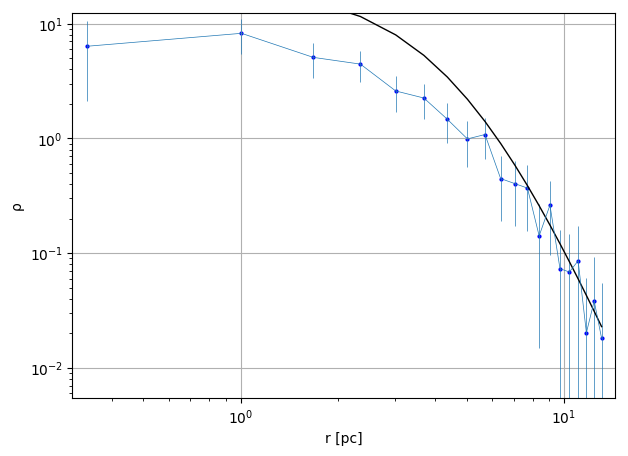

## metasolution:
_modelCauchy(22.28994592960092, 5.071804445868611, 3.3812950367482255)
## Fit error:
_modelCauchy(0.6888063910773378, 0.23674345133682784, 0.2222996630758506)


In [36]:
## binned density
r2d,ρ2d,err2d= _density2D(oc.Y, oc.Z, nbin)    ## binned radius
## local density
nloc= 2
rad_2d, loc_2d= _locdens2d(oc.Y, oc.Z, nloc)    ## density estimated for each point
 
ρ2dfit= _model_rad(r2d, θfit, _fdens1)

fig= PyPlot.figure(figsize=(7,5))

ax= PyPlot.subplot(111)
ax.set_xlabel("r [pc]")
ax.set_ylabel("ρ")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(r2d[1]*0.9, r2d[end]*1.1)
ax.set_ylim(minimum(ρ2d[ρ2d .> 0])*0.3,maximum(ρ2d)*1.5)
PyPlot.grid("on")
PyPlot.scatter(r2d, ρ2d , s=4, facecolor="blue" )
PyPlot.errorbar(r2d, ρ2d, yerr=2 .* err2d, linewidth=0.5)
# PyPlot.scatter(rad_2d, loc_2d , s=2, facecolor="red" )
PyPlot.plot(r2d, ρ2dfit, "k-", linewidth=1)

PyPlot.show()

println("## metasolution:")
println(θfit)
println("## Fit error:")
println(θfiterr)

-----------------------------------
## Loop over all OCs
### !!!! the fixed version is in /src !!

In [37]:
cd(ocdir)
files= glob("*csv")
cd(wdir)

ilabel= []

doIt= false
i= 0
for f in files
    i+= 1
    # oc= CSV.read("$ocdir/$f" , delim= ";")
    ocfile= "$ocdir/$f"
    println("## ocfile: $f")
    println("## fitting the radial profile....")
    
    ntest= 50 ; nbin=20 ; niter=50000
    if doIt
        θfit, θfiterr= _extract_parameter(ocfile, ntest, nbin, niter, true)
        
        println(θfit)
        println(θfiterr)
        println(" ")
        push!(ilabel, i) 
    end
    

end


## ocfile: ASCC 10-2.7deg-oc-mass.csv
## fitting the radial profile....
## ocfile: ASCC 10-2.7deg-oc.csv
## fitting the radial profile....
## ocfile: ASCC 100-1.8deg-oc-mass.csv
## fitting the radial profile....
## ocfile: ASCC 100-1.8deg-oc.csv
## fitting the radial profile....
## ocfile: ASCC 101-2.5deg-oc-mass.csv
## fitting the radial profile....
## ocfile: ASCC 101-2.5deg-oc.csv
## fitting the radial profile....
## ocfile: ASCC 103-1.4deg-oc-mass.csv
## fitting the radial profile....
## ocfile: ASCC 103-1.4deg-oc.csv
## fitting the radial profile....
## ocfile: ASCC 108-1.0deg-oc-mass.csv
## fitting the radial profile....
## ocfile: ASCC 108-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: ASCC 11-2.0deg-oc-mass.csv
## fitting the radial profile....
## ocfile: ASCC 11-2.0deg-oc.csv
## fitting the radial profile....
## ocfile: ASCC 113-1.7deg-oc-mass.csv
## fitting the radial profile....
## ocfile: ASCC 113-1.7deg-oc.csv
## fitting the radial profile....
## ocfile: ASCC 1

## ocfile: Collinder 121-2.4deg-oc-mass.csv
## fitting the radial profile....
## ocfile: Collinder 121-2.4deg-oc.csv
## fitting the radial profile....
## ocfile: Collinder 135-2.6deg-oc-mass.csv
## fitting the radial profile....
## ocfile: Collinder 135-2.6deg-oc.csv
## fitting the radial profile....
## ocfile: Collinder 140-2.5deg-oc-mass.csv
## fitting the radial profile....
## ocfile: Collinder 140-2.5deg-oc.csv
## fitting the radial profile....
## ocfile: Collinder 197-1.1deg-oc-mass.csv
## fitting the radial profile....
## ocfile: Collinder 197-1.1deg-oc.csv
## fitting the radial profile....
## ocfile: Collinder 223-1.0deg-oc-mass.csv
## fitting the radial profile....
## ocfile: Collinder 223-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: Collinder 394-1.5deg-oc-mass.csv
## fitting the radial profile....
## ocfile: Collinder 394-1.5deg-oc.csv
## fitting the radial profile....
## ocfile: Collinder 419-1.0deg-oc-mass.csv
## fitting the radial profile....
## ocfile: Colli

## ocfile: FSR 1180-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: FSR 1183-1.0deg-oc-mass.csv
## fitting the radial profile....
## ocfile: FSR 1183-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: FSR 1194-1.0deg-oc-mass.csv
## fitting the radial profile....
## ocfile: FSR 1194-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: FSR 1199-1.0deg-oc-mass.csv
## fitting the radial profile....
## ocfile: FSR 1199-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: FSR 1200-1.0deg-oc-mass.csv
## fitting the radial profile....
## ocfile: FSR 1200-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: FSR 1204-1.0deg-oc-mass.csv
## fitting the radial profile....
## ocfile: FSR 1204-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: FSR 1281-1.0deg-oc-mass.csv
## fitting the radial profile....
## ocfile: FSR 1281-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: FSR 1284-1.0deg-oc-mass.csv
## fitting the radial profile....
## ocfile: FS

## fitting the radial profile....
## ocfile: Loden 694-1.2deg-oc.csv
## fitting the radial profile....
## ocfile: Lynga 1-1.0deg-oc-mass.csv
## fitting the radial profile....
## ocfile: Lynga 1-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: Lynga 2-1.0deg-oc-mass.csv
## fitting the radial profile....
## ocfile: Lynga 2-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: Lynga 4-1.0deg-oc-mass.csv
## fitting the radial profile....
## ocfile: Lynga 4-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: MWSC 5309-1.0deg-oc-mass.csv
## fitting the radial profile....
## ocfile: MWSC 5309-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: MWSC 5311-1.0deg-oc-mass.csv
## fitting the radial profile....
## ocfile: MWSC 5311-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: MWSC 5316-1.1deg-oc-mass.csv
## fitting the radial profile....
## ocfile: MWSC 5316-1.1deg-oc.csv
## fitting the radial profile....
## ocfile: Melotte 101-1.2deg-oc-mass.csv
## fittin

## fitting the radial profile....
## ocfile: NGC 2567-1.0deg-oc-mass.csv
## fitting the radial profile....
## ocfile: NGC 2567-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: NGC 2571-1.0deg-oc-mass.csv
## fitting the radial profile....
## ocfile: NGC 2571-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: NGC 2632-15.5deg-oc-mass.csv
## fitting the radial profile....
## ocfile: NGC 2632-15.5deg-oc.csv
## fitting the radial profile....
## ocfile: NGC 2669-1.4deg-oc-mass.csv
## fitting the radial profile....
## ocfile: NGC 2669-1.4deg-oc.csv
## fitting the radial profile....
## ocfile: NGC 2670-1.0deg-oc-mass.csv
## fitting the radial profile....
## ocfile: NGC 2670-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: NGC 2671-1.0deg-oc-mass.csv
## fitting the radial profile....
## ocfile: NGC 2671-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: NGC 2682-5.2deg-oc-mass.csv
## fitting the radial profile....
## ocfile: NGC 2682-5.2deg-oc.csv
## fitting 

## ocfile: NGC 7762-1.1deg-oc.csv
## fitting the radial profile....
## ocfile: NGC 7789-2.1deg-oc-mass.csv
## fitting the radial profile....
## ocfile: NGC 7789-2.1deg-oc.csv
## fitting the radial profile....
## ocfile: NGC 886-1.0deg-oc-mass.csv
## fitting the radial profile....
## ocfile: NGC 886-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: NGC 957-1.4deg-oc-mass.csv
## fitting the radial profile....
## ocfile: NGC 957-1.4deg-oc.csv
## fitting the radial profile....
## ocfile: PTB 9-1.5deg-oc-mass.csv
## fitting the radial profile....
## ocfile: PTB 9-1.5deg-oc.csv
## fitting the radial profile....
## ocfile: Patchick 75-1.0deg-oc-mass.csv
## fitting the radial profile....
## ocfile: Patchick 75-1.0deg-oc.csv
## fitting the radial profile....
## ocfile: Per OB2-4.0deg-oc-mass.csv
## fitting the radial profile....
## ocfile: Per OB2-4.0deg-oc.csv
## fitting the radial profile....
## ocfile: Pismis 14-1.0deg-oc-mass.csv
## fitting the radial profile....
## ocfile: Pismis 